# Visibility

## Table of Contents



## I. Usability elements

Import required packages 

In [1]:
## required packages
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

### I.I Angle classes

To handle the different formats in which one can express the value of an angle on celestial sphere (radiants, degrees, hours), two classes of object are defined. These keep the value of an angle in different units and provide some usefull function to convert from one format to an other.

In [2]:
## angle classes
class Angles():
    """Class to handle with angles in degrees or radiants.
    The class keeps the value of an angle in deg and rad and gives the functions to convert the one in the other.

    :param deg: the amplitude of the angle in [degrees, primes, seconds], defaults to np.zeros(3)
    :type deg: numpy_array, optional
    :param rad: the amplitude of the angle in radiants, defaults to 0
    :type rad: float, optional
    """
    def __init__(self, deg = np.zeros(3), rad = 0.0) -> None:
        """The constructor of the class"""
        self.deg = deg
        self.rad = rad

    def deg_check(self) -> None:
        """The shape of the angle value in deg is [int (<360), int (<60), float (<60)]. 
        This function checks and adjusts the format of the angle value.

        :rtype: None
        """
        for i in range(2):
            diff = self.deg[i] % 1
            if diff != 0:
                self.deg[i] = int(self.deg[i])
                self.deg[i+1] += diff*60
        self.deg[2] = round(self.deg[2], 3)
        if self.deg[2] >= 60 :
            tmp = self.deg[2]
            self.deg[2] = tmp % 60
            self.deg[1] += tmp // 60
        if self.deg[1] >= 60 :
            tmp = self.deg[1]
            self.deg[1] = tmp % 60
            self.deg[0] += tmp // 60
        if self.deg[0] > 360 :
            self.deg[0] -= 360

    def deg_to_rad(self) -> None:
        """The function converts deg value in rad one of an angle

        :rtype: None
        """
        ang = self.deg[0] + self.deg[1]/60 + self.deg[2]/3600
        self.rad = ang / 180 * pi

    def rad_to_deg(self) -> None:
        """The function converts rad value of an angle in deg one

        :rtype: None
        """
        ang = self.rad / pi * 180
        # if(ang > 360):
        #     ang - 360
        self.deg = np.array([ang, 0, 0])
        self.deg_check()

    def angle_init(self) -> None:
        """The function checks deg value of an angle and assigns the respective rad one 

        :rtype: None
        """
        if self.rad == 0.0 :
            self.deg_check()
            self.deg_to_rad()
        else:
            self.rad_to_deg()   
    
    def all_deg(self):
        ang = self.rad * 180 / pi
        return ang
        

class HAngles(Angles):
    """This is essentially the same class as :class: `Angles`, keeping in account the description of an angle in [hours,minutes,seconds] format.

    :param deg: parameter from :class: `Angles`
        the amplitude of the angle in [degrees, primes, seconds], defaults to np.zeros(3)
    :type deg: numpy_array, optional
    :param rad: parameter from :class: `Angles`
        the amplitude of the angle in radiants, defaults to 0
    :type rad: float, optional
    :param hms: the amplitude of the angle in [h, m, s], defaults to np.zeros(3)
    :type deg: numpy_array, optional
   """
    def __init__(self, deg = np.zeros(3), rad = 0, hms = np.zeros(3)) -> None:
        """The constructor function"""
        super().__init__(deg,rad)
        self.hms = hms

    def hms_check(self) -> None:
        """The shape of the angle value in hms is [int, int (<60), float (<60)]. 
        This function checks and adjusts the format of the angle value.
        """
        for i in range(2):
            diff = self.hms[i] % 1
            if diff != 0:
                self.hms[i] = int(self.hms[i])
                self.hms[i+1] += diff*60
        self.hms[2] = round(self.hms[2], 3)
        if self.hms[2] >= 60 :
            tmp = self.hms[2]
            self.hms[2] = tmp % 60
            self.hms[1] += tmp // 60
        if self.hms[1] >= 60 :
            tmp = self.hms[1]
            self.hms[1] = tmp % 60
            self.hms[0] += tmp // 60

    def deg_to_hms(self) -> None:
        """The function converts deg value of an angle in hms one

        :rtype: None
        """
        self.hms = self.deg / 15
        self.hms_check()

    def hms_to_deg(self) -> None:
        """The function converts hms value of an angle in deg one

        :rtype: None
        """
        self.deg = self.hms * 15
        self.deg_check()

    def angle_init(self) -> None:
        """The function checks if angle is given in deg or hms format then assigns the respective values for the other formats 

        :rtype: None
        """
        if self.rad != 0.0 :
            self.rad_to_deg()
            self.deg_to_hms()
        elif all(self.hms == np.zeros(3)) :
            self.deg_check()
            self.deg_to_hms()
            self.deg_to_rad()
        else:
            self.hms_check()
            self.hms_to_deg()
            self.deg_to_rad()


def complementary(theta : Angles or HAngles) -> Angles or HAngles :
    """This function takes an angle and returns its complementary.
    The angles are objects :class: `Angles` or `HAngles`.

    :param theta: the angle
    :type theta: :class: `Angles` or :class: `HAngles`
    
    :return: the complementar angle
    :rtype: :class: `Angles` or :class: `HAngles`
    """
    class_type = type(theta)
    compl_angle = class_type(rad = (pi/2 - theta.rad))
    compl_angle.angle_init()
    return compl_angle


### I.II Input data

## II. Time

## III. Trajectory along the sky

-6.2301113055904676 6.2301113055904676


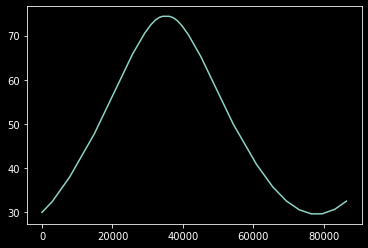

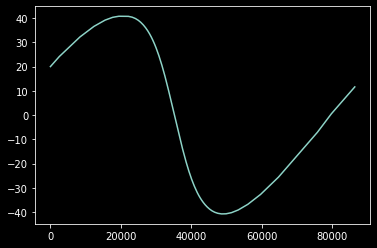

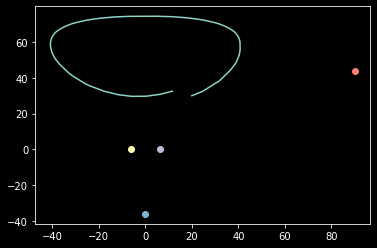

In [7]:
## object trajectory along the sky 
##* From ref 2. in `README.md` eq. 24, 25
def rise_set_culmination(delta : float, lat : float) -> list:
    transit = pi/2 - (lat - delta)
    low_culm = (lat + delta) - pi/2
    if low_culm > 0 :
        set = [0., 0.]
        rise = [0., 0.]
    else:
        set_ha = np.arccos(-1 * np.tan(delta) * np.tan(lat))
        set_az = np.arccos(np.sin(delta) / np.cos(lat)) - pi/2 
        rise_ha = 2*pi - set_ha
        rise_az = -1 * set_az
        set = [set_ha, set_az]
        rise = [rise_ha, rise_az]
    return transit, low_culm, set, rise

##* From ref 2. in `README.md` eq. 26, 27
def step(alt : Angles, az : Angles, lat : Angles, n : int):
    alt_data = []
    az_data = []
    phi = lat.rad
    alt_n = alt
    az_n = az
    for i in range(n):
        z = complementary(alt_n)
        alt_n.deg[2] = alt_n.deg[2] + 15 * np.sin(az_n.rad) * np.cos(phi)
        alt_n.deg_to_rad()
        az_n.deg[2] = az_n.deg[2] + 15 * (np.sin(phi) - np.cos(phi) * np.cos(az_n.rad) / np.tan(z.rad))  
        az_n.deg_to_rad()

        alt_n.deg_check()
        az_n.deg_check()
        
        alt_data += [alt_n.rad]
        az_data += [az_n.rad]
    return np.array(alt_data), np.array(az_data)

#def time_evolution(alt : Angles, az : Angles, lat : Angles, n : int):

alt0 = Angles(np.array([30,0,0]))
alt0.angle_init()
az0 = Angles(np.array([20,0,0])) 
az0.angle_init()
lat0 = Angles(np.array([50,0,0]))
lat0.angle_init()
delta = 4 * pi / 180

transit, low, set, rise = rise_set_culmination(delta, lat0.rad)
set = set[1]*180/pi
rise = rise[1]*180/pi
#print()

print(set, rise)

n = 24 * 3600

alt, az = step(alt0, az0, lat0, n)

plt.figure(1)
plt.plot(np.arange(n),alt*180/pi)
plt.figure(2)
plt.plot(np.arange(n),az*180/pi)
plt.figure(3)
plt.plot(az*180/pi, alt*180/pi)
plt.plot([set],[0],'o')
plt.plot([rise],[0],'o')
plt.plot([90],[transit*180/pi],'o')
plt.plot([0],[low*180/pi],'o')
#plt.plot([])

## IV. Sun

### IV.I Twilight

## V. Moon

### V.I Moon Phases